#Importation des données et des librairies

In [ ]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
# import warnings
# warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight');

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier

from sklearn import metrics


import gc



In [ ]:
#Contient la variable TARGET
train_corrs_removed = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet_7/input/train_bureau_corrs_removed.csv')

#Ne contient pas de variable TARGET
test_corrs_removed = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet_7/input/test_bureau_corrs_removed.csv')




In [ ]:
train_corrs_removed.shape 

(307511, 199)

In [ ]:
test_corrs_removed.shape

(48744, 198)

In [ ]:
#####################################################################
features = train_corrs_removed
test_features = test_corrs_removed

features.fillna(features.median(), inplace=True)

# Extract the ids
train_ids = features['SK_ID_CURR']
test_ids = test_features['SK_ID_CURR']

# Extract the labels for training
labels = features['TARGET']

# Remove the ids and target
features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
test_features = test_features.drop(columns = ['SK_ID_CURR'])


# One Hot Encoding
features = pd.get_dummies(features)
test_features = pd.get_dummies(test_features)

# Align the dataframes by the columns
features, test_features = features.align(test_features, join = 'inner', axis = 1)

# No categorical indices to record
cat_indices = 'auto'



print('Training Data Shape: ', features.shape)
print('Testing Data Shape: ', test_features.shape)

Training Data Shape:  (307511, 318)
Testing Data Shape:  (48744, 318)


In [ ]:
# %%time
# features.to_csv('/content/drive/My Drive/Colab Notebooks/Projet_7/features.csv')
# test_features.to_csv('/content/drive/My Drive/Colab Notebooks/Projet_7/test_features.csv')

In [ ]:
test_corrs_removed.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,...,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_STATUS_0_count_mean,client_bureau_balance_STATUS_0_count_max,client_bureau_balance_STATUS_0_count_min,client_bureau_balance_STATUS_0_count_norm_mean,client_bureau_balance_STATUS_0_count_norm_max,client_bureau_balance_STATUS_0_count_norm_min,client_bureau_balance_STATUS_1_count_mean,client_bureau_balance_STATUS_1_count_max,client_bureau_balance_STATUS_1_count_min,client_bureau_balance_STATUS_1_count_norm_mean,client_bureau_balance_STATUS_1_count_norm_max,client_bureau_balance_STATUS_1_count_norm_min,client_bureau_balance_STATUS_2_count_mean,client_bureau_balance_STATUS_2_count_max,client_bureau_balance_STATUS_2_count_min,client_bureau_balance_STATUS_2_count_norm_mean,client_bureau_balance_STATUS_2_count_norm_min,client_bureau_balance_STATUS_3_count_mean,client_bureau_balance_STATUS_3_count_max,client_bureau_balance_STATUS_3_count_min,client_bureau_balance_STATUS_3_count_norm_mean,client_bureau_balance_STATUS_3_count_norm_min,client_bureau_balance_STATUS_4_count_mean,client_bureau_balance_STATUS_4_count_max,client_bureau_balance_STATUS_4_count_min,client_bureau_balance_STATUS_4_count_sum,client_bureau_balance_STATUS_4_count_norm_min,client_bureau_balance_STATUS_5_count_mean,client_bureau_balance_STATUS_5_count_max,client_bureau_balance_STATUS_5_count_min,client_bureau_balance_STATUS_C_count_mean,client_bureau_balance_STATUS_C_count_min,client_bureau_balance_STATUS_C_count_norm_max,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2,TUESDAY,18,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,...,0.0,4.428571,12.0,1.0,0.336651,1.000000,0.019231,0.142857,1.0,0.0,0.007519,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.714286,0.0,0.966667,4.285714,9.0,0.0,0.214590,0.500000,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2,FRIDAY,9,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,...,0.0,4.666667,7.0,2.0,0.735043,1.000000,0.538462,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.666667,0.0,0.384615,0.666667,1.0,0.0,0.136752,0.333333,0.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2,MONDAY,14,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,...,0.0,19.750000,34.0,0.0,0.320718,0.618182,0.000000,1.750000,3.0,0.0,0.027701,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.750000,0.0,0.666667,10.250000,40.0,0.0,0.254545,1.000000,0.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-20

#Modelling

In [ ]:
train_corrs_removed.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, stratify=labels, random_state=1)

## Dummy classification

In [ ]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [ ]:
y_pred4 = dummy_clf.predict(X_test)

In [ ]:
#TN FP
#FN TP
# confusion_matrix(y_test, y_pred4)

In [ ]:
print(classification_report(y_test, y_pred4, zero_division=0))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84806
           1       0.00      0.00      0.00      7448

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



##Logistic regression

In [ ]:
t = X_train.fillna(X_train.median())
u = y_train.fillna(y_train.median())
t_scale = preprocessing.scale(t)

In [ ]:
%%time
LR = LogisticRegression(random_state=1, max_iter=1000).fit(t_scale, u)
y_pred3 = LR.predict(X_test.fillna(X_test.median()))

CPU times: user 2min 12s, sys: 12.3 s, total: 2min 25s
Wall time: 1min 13s


In [ ]:
#TN FP
#FN TP
# confusion_matrix(y_test, y_pred3)

In [ ]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.92      0.68      0.78     84806
           1       0.08      0.30      0.12      7448

    accuracy                           0.65     92254
   macro avg       0.50      0.49      0.45     92254
weighted avg       0.85      0.65      0.73     92254



##Gradient boosting classifier

### Without tunning

J'utilise un premier modèle de gradient boosting sans rééquilibre des classes pour avoir une première idée des résultats

In [ ]:
%%time
Lgb = lgb.LGBMClassifier(n_estimators=1000, 
                         objective = 'binary',  
                         #scale_pos_weight = 1e12,
                         #class_weight = 'balanced',
                         reg_alpha = 0.1, 
                         reg_lambda = 0.1, 
                         subsample = 0.8,
                         n_jobs = -1, 
                         random_state = 50)

fit_model = Lgb.fit(X_train, y_train)
y_pred = Lgb.predict(X_test)

CPU times: user 3min 12s, sys: 494 ms, total: 3min 12s
Wall time: 1min 39s


In [ ]:
#TN FP
#FN TP
# confusion_matrix(y_test, y_pred)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84806
           1       0.51      0.04      0.08      7448

    accuracy                           0.92     92254
   macro avg       0.72      0.52      0.52     92254
weighted avg       0.89      0.92      0.89     92254



On pouvait s'attendre aux résultats ci-dessus qui semblent un peu mieux que la baseline mais ce n'est pas suffisant

### With tunning

Je vais dans cette partie, je vais utilisé une métrique d'évaluation métier ainsi que le paramètre 'class_weight' pour rééquilibrer le jeu de donnée pendant l'entrainement du modèle

Ci-dessous la métrique métier avec les explications

In [ ]:
def credit_metric(y_true, y_pred):

    #Ci-dessous les poids attribués arbitrairement

    fn_coeff = -10 #Mauvais clients que l'on n'a pas reussi à identifier == Perte
    fp_coeff = 0   #Bons clients que l'on n'a pas reussi à identifier == Manque à gagner
    tp_coeff = 0   #Mauvais clients que l'on a reussi à identifier == Argent sauvé
    tn_coeff = 1   #Bons clients que l'on a reussi à identifier == Gain

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred.round())
    
    # True Negatives
    tn = mat_conf[0, 0]
    # False Negatives
    fn = mat_conf[1, 0]
    # False Positives
    fp = mat_conf[0, 1]
    # True Positives
    tp = mat_conf[1, 1]
    
    # Gain total
    G = tp*tp_coeff + tn*tn_coeff + fp*fp_coeff + fn*fn_coeff # 0 TP + 1 TN + 0 FP - 10 FN
    
    # Gain maximum
    G_max = (fp + tn)*tn_coeff + (fn + tp)*tp_coeff
    
    # Gain minimum
    G_min = (fp + tn)*fp_coeff + (fn + tp)*fn_coeff
    
    # Gain normalisé entre 0 et 1, plus on tend vers 1, mieux c'est
    G_normalized = (G - G_min)/(G_max - G_min)
    
    return "credit_metric", G_normalized, True  # Retourne la fonction d'évaluation

Le mode "balanced" du paramètre class_weight utilise les valeurs de y pour ajuster automatiquement les poids inversement proportionnels aux fréquences de classe dans les données d'entrée

In [ ]:
%%time

Lgb_tun = lgb.LGBMClassifier(n_estimators=1000, 
                         objective = 'binary',  
                         #scale_pos_weight = 1e12,
                         class_weight = 'balanced',
                         reg_alpha = 0.1, 
                         reg_lambda = 0.1, 
                         subsample = 0.8,
                         n_jobs = -1, 
                         random_state = 50)

fit_model = Lgb_tun.fit(X_train, y_train, 
                     eval_metric=credit_metric,
                     early_stopping_rounds=50,
                     eval_set = [(X_test,y_test), (X_train, y_train)],
                     eval_names = ['valid', 'train'],
                     verbose=False,
                     categorical_feature="auto")

y_pred2 = Lgb_tun.predict(X_test)

CPU times: user 4min 32s, sys: 513 ms, total: 4min 33s
Wall time: 3min 56s


In [ ]:
Lgb_tun.best_score_

defaultdict(dict,
            {'train': {'binary_logloss': 0.5322494990826578,
              'credit_metric': 0.7323987622763353},
             'valid': {'binary_logloss': 0.5515642157906153,
              'credit_metric': 0.6958489760556483}})

J'obtiens un score de 0.70 pour la métrique métrique métier, ce qui représente un bon score

In [ ]:
#TN FP
#FN TP
confusion_matrix(y_test, y_pred2)


array([[60979, 23827],
       [ 2462,  4986]])

In [ ]:
print(classification_report(y_test, y_pred2, zero_division=0))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     84806
           1       0.17      0.67      0.28      7448

    accuracy                           0.72     92254
   macro avg       0.57      0.69      0.55     92254
weighted avg       0.90      0.72      0.78     92254



En regardant les scores ci-dessus on peut également observer que l'on a obtenu de meilleurs résultats que la baseline, car on a beaucoup gagné en recall, la contrepartie a été l'accuracy. 

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

###Random search

Pour la recherche des meilleurs paramètres, je vais travailler sur un plus petit échantillon

In [ ]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(features, labels, train_size=0.1, stratify=labels, random_state=1)

In [ ]:
X_test_small = X_test_small.sample(n=10000, random_state=1)
y_test_small = y_test_small.sample(n=10000, random_state=1)


In [ ]:
X_train.shape

(215257, 318)

In [ ]:
X_train_small.shape

(30751, 318)

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
param_test ={
            'num_leaves': [10,50,100,1000], 
            'min_child_samples': [100,250,500], 
            'min_child_weight': [1e-5, 1e-1, 1, 1e1, 1e3],          
            'reg_alpha': [0, 1e-1, 1, 5, 10, 50, 100],
            'reg_lambda': [0, 1e-1, 1, 5, 10, 50, 100]
            }


fit_params = {'eval_metric' : 'credit_metric',
              'early_stopping_rounds' : 50,
              'eval_set' : [(X_test,y_test), (X_train, y_train)],
              'eval_names' : ['valid', 'train'],
              'verbose': 100
}

clf = RandomizedSearchCV(Lgb_tun, param_test)
clf.fit(X_train_small, y_train_small, **fit_params)


In [ ]:
clf.best_score_

0.8994829421615627

In [ ]:
clf.best_params_

{'min_child_samples': 100,
 'min_child_weight': 1,
 'num_leaves': 50,
 'reg_alpha': 5,
 'reg_lambda': 0.1}

Ci-dessus les meilleurs paramètres trouvés par le random search, je vais les implémenter dans mon précédent modèle

In [ ]:
%%time

Lgb_best = lgb.LGBMClassifier(n_estimators=1000, 
                         objective = 'binary',  
                         #scale_pos_weight = 1e12,
                         class_weight = 'balanced',
                         min_child_samples = 100,
                         min_child_weight = 1,
                         num_leaves = 50,
                         reg_alpha = 5, 
                         reg_lambda = 0.1,                         
                         n_jobs = -1, 
                         random_state = 50)

fit_best_model = Lgb_best.fit(X_train, y_train, 
                     eval_metric=credit_metric,
                     early_stopping_rounds=50,
                     eval_set = [(X_test,y_test), (X_train, y_train)],
                     eval_names = ['valid', 'train'],
                     verbose=False,
                     categorical_feature="auto")

y_pred_best = Lgb_best.predict(X_test)

CPU times: user 4min 32s, sys: 457 ms, total: 4min 33s
Wall time: 3min 52s


In [ ]:
#Sans random search
print(classification_report(y_test, y_pred2, zero_division=0))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     84806
           1       0.17      0.67      0.28      7448

    accuracy                           0.72     92254
   macro avg       0.57      0.69      0.55     92254
weighted avg       0.90      0.72      0.78     92254



In [ ]:
#Avec random search
print(classification_report(y_test, y_pred_best, zero_division=0))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     84806
           1       0.18      0.66      0.28      7448

    accuracy                           0.72     92254
   macro avg       0.57      0.69      0.55     92254
weighted avg       0.90      0.72      0.78     92254



L'optimisation des hyperparamètres avec un échantillon réduit permet d'obtenir de meilleurs résultats mais celà reste très léger

In [ ]:
from joblib import dump, load
# dump(Lgb, '/content/drive/My Drive/Colab Notebooks/Projet_7/lgb_neg_weights.joblib')
# dump(Lgb_tun, '/content/drive/My Drive/Colab Notebooks/Projet_7/lgb_tun.joblib')

['/content/drive/My Drive/Colab Notebooks/Projet_7/lgb_tun.joblib']

#Interprétabilité

Pour l'interprétabilité du modèle, je vais utiliser LIME

##LIME

In [ ]:
!pip install lime

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=49b3af295ce5964c7a3bde699b89e6687baa3aefdb990ce20de437aa4d88a835
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
import lime #LIME package
import lime.lime_tabular #the type of LIIME analysis we’ll do

from lime.lime_tabular import LimeTabularExplainer
from sklearn.neighbors import NearestNeighbors


In [ ]:
test_features.fillna(test_features.median(), inplace=True)

In [ ]:
lime1 = LimeTabularExplainer(test_features,
                             feature_names=test_features.columns,
                             discretize_continuous=False)
                            

exp = lime1.explain_instance(test_features.iloc[test_corrs_removed.index[test_corrs_removed['SK_ID_CURR']==int(100005)]].T.squeeze(),
                             Lgb_tun.predict_proba,
                             num_samples=1000)

In [ ]:
test_features.iloc[2]

CNT_CHILDREN                            0.000000
AMT_INCOME_TOTAL                   202500.000000
AMT_CREDIT                         663264.000000
AMT_ANNUITY                         69777.000000
REGION_POPULATION_RELATIVE              0.019101
                                       ...      
WALLSMATERIAL_MODE_Panel                0.000000
WALLSMATERIAL_MODE_Stone, brick         0.000000
WALLSMATERIAL_MODE_Wooden               0.000000
EMERGENCYSTATE_MODE_No                  0.000000
EMERGENCYSTATE_MODE_Yes                 0.000000
Name: 2, Length: 318, dtype: float64

In [ ]:
exp_list = exp.as_list()

In [ ]:
exp_keys = []
exp_values = []
exp_positives = []
for i in range(len(exp_list)):
  exp_keys.append(exp_list[i][0])
  exp_values.append(exp_list[i][1])
  exp_positives.append(exp_values[i] > 0)

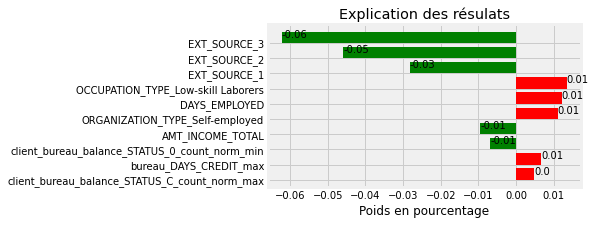

In [ ]:
x = exp_keys
y = exp_values

fig, ax = plt.subplots(figsize=(5,3))   

width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(x, y, width, color=pd.Series(exp_positives).map({True: 'r', False: 'g'}))
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.gca().invert_yaxis()
plt.title('Explication des résulats')
plt.xlabel('Poids en pourcentage')      
for index, value in enumerate(y):
    plt.text(value, index, str(np.round(value, decimals=2)))

In [ ]:
# %%time
# from sklearn.neighbors import NearestNeighbors
# neigh = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(test_features)


In [ ]:
# index = test_corrs_removed[test_corrs_removed["SK_ID_CURR"] == 100005].index.values

# data_client = test_features.iloc[index[0]]
# data_client = data_client.values.reshape(1, -1)

# indices = neigh.kneighbors(data_client, return_distance=False)